### **Download dataset from SoccerNet**

In [13]:
import sys
!"{sys.executable}" -m pip install SoccerNet --upgrade
!"{sys.executable}" -m pip install ultralytics 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [14]:
import os
import zipfile
import cv2
import random
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from SoccerNet.Downloader import SoccerNetDownloader
from ultralytics import YOLO

In [15]:
mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="SoccerNet Data")

In [16]:
# Download train/test splits for tracking
mySoccerNetDownloader.password = "s0cc3rn3t"
mySoccerNetDownloader.downloadDataTask(task="tracking-2023", split=["train", "test", "challenge"])

SoccerNet Data\tracking-2023\train.zip already exists
SoccerNet Data\tracking-2023\test.zip already exists
SoccerNet Data\tracking-2023\challenge2023.zip already exists


In [17]:
data_dir = r"C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023"
for fname in ["train.zip", "test.zip", "challenge2023.zip"]:
    fpath = os.path.join(data_dir, fname)
    if os.path.exists(fpath):
        size_gb = os.path.getsize(fpath) / (1024**3)
        print(fname, "size:", f"{size_gb:.2f} GB")

train.zip size: 8.92 GB
test.zip size: 8.11 GB
challenge2023.zip size: 4.95 GB


In [18]:
# Extract train/test/challenge if not already extracted
zip_files = [
    os.path.join(data_dir, "train.zip"),
    os.path.join(data_dir, "test.zip"),
    os.path.join(data_dir, "challenge2023.zip")
]

for zf in zip_files:
    if os.path.exists(zf):
        extract_path = os.path.splitext(zf)[0]  # train.zip → train/
        if not os.path.exists(extract_path):
            print(f"Extracting {zf}...")
            with zipfile.ZipFile(zf, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
        else:
            print(f"{extract_path} already extracted.")

C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\train already extracted.
C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\test already extracted.
C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\challenge2023 already extracted.


In [19]:
# Look for yaml files
yaml_files = glob.glob(os.path.join(data_dir, "**", "*.yaml"), recursive=True)
print("Found yaml files:", yaml_files)

# List a few jpg files
print("Sample images:", glob.glob(os.path.join(data_dir, "**", "*.jpg"), recursive=True)[0])

# List a few txt labels
print("Sample labels:", glob.glob(os.path.join(data_dir, "**", "*.txt"), recursive=True)[0])

# 
img = cv2.imread(test_img)
print("Image shape:", img.shape if img is not None else "Could not read image")

Found yaml files: []
Sample images: C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\challenge2023\challenge2023\SNMOT-001\img1\000001.jpg
Sample labels: C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\test\test\SNMOT-116\det\det.txt
Image shape: (1080, 1920, 3)


### **Show data sample**

In [20]:
np.random.seed(42)

In [21]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [22]:
class_names = ['player', 'referee', 'ball', 'goalkeeper']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [23]:
def plot_box(image, bboxes, labels):
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)

        class_name = class_names[int(labels[box_num])]
        color = colors[class_names.index(class_name)]

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=color, thickness=2)
        cv2.putText(image, class_name, (xmin, ymin-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    return image

In [24]:
def plot_from_sequence(data_dir, num_samples=4):
    seq_folders = glob.glob(os.path.join(data_dir, "**", "img1"), recursive=True)
    if not seq_folders:
        print("No sequence folders found.")
        return
    
    chosen_seq = random.choice(seq_folders)
    print("Chosen sequence:", chosen_seq)

    all_images = sorted(glob.glob(os.path.join(chosen_seq, "*.jpg")))
    sample_images = random.sample(all_images, min(num_samples, len(all_images)))

    plt.figure(figsize=(15, 12))
    for i, img_path in enumerate(sample_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize to avoid crash
        image = cv2.resize(image, (640, 360))

        plt.subplot(1, len(sample_images), i+1)
        plt.imshow(image)
        plt.title(os.path.basename(img_path))
        plt.axis("off")
    plt.show()


Chosen sequence: C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\test\test\SNMOT-192\img1


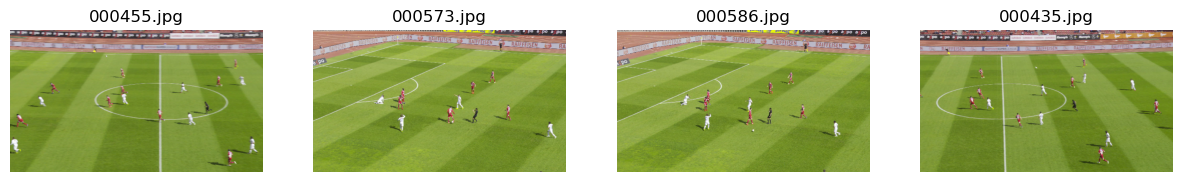

In [25]:
# Plot some samples
plot_from_sequence(data_dir, num_samples=4)

### **Apply YOLOV11**

In [26]:
# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

In [30]:
# old code for lables!!!
import os, glob, csv, shutil
from collections import defaultdict
import cv2
from pathlib import Path
import random

# === CONFIG ===
SRC_ROOT = r"C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\train\train"
OUT_ROOT = r"C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\soccernet_yolo"  # new dataset root
VAL_RATIO = 0.1  # 10% of sequences for val
IMG_EXT = ".jpg"  

random.seed(42)

# Collect all sequences
seq_dirs = sorted(glob.glob(os.path.join(SRC_ROOT, "SNMOT-*")))
print("Found train sequences:", len(seq_dirs))

# Split train/val by sequences
random.shuffle(seq_dirs)
val_count = max(1, int(len(seq_dirs) * VAL_RATIO))
val_seqs = set(seq_dirs[:val_count])
train_seqs = set(seq_dirs[val_count:])
print(f"Split => train {len(train_seqs)} seqs, val {len(val_seqs)} seqs")

# Create output dirs
for split in ["train", "val"]:
    (Path(OUT_ROOT) / "images" / split).mkdir(parents=True, exist_ok=True)
    (Path(OUT_ROOT) / "labels" / split).mkdir(parents=True, exist_ok=True)

def link_or_copy(src, dst):
    dst_parent = os.path.dirname(dst)
    os.makedirs(dst_parent, exist_ok=True)
    try:
        os.link(src, dst)  # hardlink
    except Exception:
        shutil.copy2(src, dst)

total_boxes = {"train": 0, "val": 0}
total_images = {"train": 0, "val": 0}
skipped = 0

for seq in seq_dirs:
    split = "val" if seq in val_seqs else "train"
    img_dir = os.path.join(seq, "img1")
    gt_path = os.path.join(seq, "gt", "gt.txt")
    if not os.path.exists(gt_path):
        print("No gt.txt in", seq, "-> skipping")
        continue

    # Build mapping: frame -> list of boxes [x,y,w,h]
    frame_boxes = defaultdict(list)
    with open(gt_path, "r", newline="") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row: 
                continue
            # MOT format: frame,id,x,y,w,h,conf,*,*,*
            frame = int(row[0])
            # id = int(row[1])  # unused for detection
            x = float(row[2]); y = float(row[3]); w = float(row[4]); h = float(row[5])
            conf = float(row[6])
            if conf < 0.5:  # keep only valid GT (usually conf==1)
                continue
            frame_boxes[frame].append((x, y, w, h))

    # Read image size once
    sample_img = sorted(glob.glob(os.path.join(img_dir, f"*{IMG_EXT}")))
    if not sample_img:
        print("No images in", img_dir, "-> skipping")
        continue
    sample_img0 = sample_img[0]
    img0 = cv2.imread(sample_img0)
    if img0 is None:
        print("Could not read", sample_img0, "-> skipping seq")
        continue
    H, W = img0.shape[:2]

    # For each image file, create matching label file
    for img_path in sorted(glob.glob(os.path.join(img_dir, f"*{IMG_EXT}"))):
        fname = os.path.basename(img_path)              # e.g. 000123.jpg
        stem = os.path.splitext(fname)[0]               # e.g. 000123
        try:
            frame_id = int(stem)
        except ValueError:
            # If names are not numeric, derive from order (fallback)
            # But SoccerNet uses numeric like 000001.jpg, so this should be fine.
            skipped += 1
            continue

        boxes = frame_boxes.get(frame_id, [])
        # Prepare YOLO label lines
        lines = []
        for (x, y, w, h) in boxes:
            # clamp and discard invalid
            if w <= 1 or h <= 1:
                continue

            x_c = (x + w/2.0) / W
            y_c = (y + h/2.0) / H
            ww  = w / W
            hh  = h / H

            # clamp to [0,1] to be safe
            x_c = min(max(x_c, 0.0), 1.0)
            y_c = min(max(y_c, 0.0), 1.0)
            ww  = min(max(ww,  0.0), 1.0)
            hh  = min(max(hh,  0.0), 1.0)

            # single-class: 0 = player
            lines.append(f"0 {x_c:.6f} {y_c:.6f} {ww:.6f} {hh:.6f}")

        # Skip images with no boxes (common in tracking)
        if not lines:
            continue

        # Destination paths (preserve sequence folder to avoid name collisions)
        dst_img = os.path.join(OUT_ROOT, "images", split, Path(seq).name, fname)
        dst_lbl = os.path.join(OUT_ROOT, "labels", split, Path(seq).name, f"{stem}.txt")

        # link/copy image and write label
        link_or_copy(img_path, dst_img)
        os.makedirs(os.path.dirname(dst_lbl), exist_ok=True)
        with open(dst_lbl, "w", newline="\n") as f:
            f.write("\n".join(lines))

        total_images[split] += 1
        total_boxes[split]  += len(lines)

print("Done.")
print("Train images with labels:", total_images["train"], "boxes:", total_boxes["train"])
print("Val   images with labels:", total_images["val"],   "boxes:", total_boxes["val"])
print("Skipped (non-numeric names etc.):", skipped)

# Write a data.yaml next to OUT_ROOT
data_yaml = os.path.join(OUT_ROOT, "data.yaml")
with open(data_yaml, "w", newline="\n", encoding="utf-8") as f:
    f.write(
f"""# YOLO data config for SoccerNet Tracking (single-class: player)
path: {OUT_ROOT.replace(os.sep, '/')}
train: images/train
val: images/val

nc: 1
names: ['player']
"""
    )
print("Wrote", data_yaml)



🚀 Processing train split...
⚠️ Skipping C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\train\train, missing files.

🚀 Processing val split...
⚠️ Skipping C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\test\test, missing files.

🚀 Processing challenge split...
⚠️ Skipping C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\challenge2023\challenge2023, missing files.


In [33]:
import os
import cv2
import configparser

# -----------------------------
# Mapping from trackletID (string) → YOLO class ID
# -----------------------------
def parse_gameinfo(gameinfo_path):
    config = configparser.ConfigParser()
    config.read(gameinfo_path)

    mapping = {}
    for key, value in config["Sequence"].items():
        if key.startswith("trackletid"):
            track_id = int(key.split("_")[1])
            desc = value.lower()

            if "referee" in desc:
                cls = 1
            elif "ball" in desc:
                cls = 2
            elif "goalkeeper" in desc:
                cls = 3
            else:
                cls = 0  # player default

            mapping[track_id] = cls
    return mapping


# -----------------------------
# Convert one sequence
# -----------------------------
def convert_sequence(seq_dir, output_labels_dir, output_images_dir):
    gt_file = os.path.join(seq_dir, "gt", "gt.txt")
    gameinfo_file = os.path.join(seq_dir, "gameinfo.ini")
    img_dir = os.path.join(seq_dir, "img1")

    if not (os.path.exists(gt_file) and os.path.exists(gameinfo_file) and os.path.isdir(img_dir)):
        print(f"⚠️ Missing files in {seq_dir}, skipping...")
        return

    # Load track_id → class_id mapping
    mapping = parse_gameinfo(gameinfo_file)

    # Get image size from first image
    first_img = sorted(os.listdir(img_dir))[0]
    img_path = os.path.join(img_dir, first_img)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read {img_path}, skipping sequence")
        return
    img_h, img_w = img.shape[:2]

    # Read gt.txt
    with open(gt_file, "r") as f:
        lines = f.readlines()

    labels_per_frame = {}

    for line in lines:
        frame, track_id, x, y, w, h, conf, *_ = line.strip().split(",")
        frame = int(frame)
        track_id = int(track_id)
        x, y, w, h = float(x), float(y), float(w), float(h)

        if track_id not in mapping:
            continue
        cls = mapping[track_id]

        # Convert to YOLO format (normalized cx, cy, w, h)
        cx = (x + w / 2) / img_w
        cy = (y + h / 2) / img_h
        nw = w / img_w
        nh = h / img_h

        yolo_line = f"{cls} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}\n"

        if frame not in labels_per_frame:
            labels_per_frame[frame] = []
        labels_per_frame[frame].append(yolo_line)

    # Write label files per frame
    for frame, labels in labels_per_frame.items():
        label_name = f"{frame:06d}.txt"
        with open(os.path.join(output_labels_dir, label_name), "w") as f:
            f.writelines(labels)

    # Copy image symlinks (or just rely on original images)
    for img_name in os.listdir(img_dir):
        src = os.path.join(img_dir, img_name)
        dst = os.path.join(output_images_dir, img_name)
        if not os.path.exists(dst):
            try:
                os.link(src, dst)  # hard link (saves space)
            except:
                import shutil
                shutil.copy(src, dst)


# -----------------------------
# Process split
# -----------------------------
def process_split(split_dir, output_root):
    if not os.path.isdir(split_dir):
        print(f"⚠️ {split_dir} does not exist, skipping...")
        return

    for seq_name in os.listdir(split_dir):
        seq_path = os.path.join(split_dir, seq_name)
        if not os.path.isdir(seq_path):
            continue

        print(f"📂 Processing {seq_name}...")

        out_img = os.path.join(output_root, "images")
        out_lbl = os.path.join(output_root, "labels")
        os.makedirs(out_img, exist_ok=True)
        os.makedirs(out_lbl, exist_ok=True)

        convert_sequence(seq_path, out_lbl, out_img)


# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    base_dir = r"C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023"

    splits = {
        "train": os.path.join(base_dir, "train"),
        "val": os.path.join(base_dir, "test"),
        "challenge": os.path.join(base_dir, "challenge2023"),
    }

    output_root = os.path.join(base_dir, "yolo_dataset")

    for split_name, split_dir in splits.items():
        print(f"\n🚀 Processing {split_name} split...")
        split_out = os.path.join(output_root, split_name)
        process_split(split_dir, split_out)

    print("\n✅ Conversion finished! YOLO dataset ready.")



🚀 Processing train split...
📂 Processing train...
⚠️ Missing files in C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\train\train, skipping...

🚀 Processing val split...
📂 Processing test...
⚠️ Missing files in C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\test\test, skipping...

🚀 Processing challenge split...
📂 Processing challenge2023...
⚠️ Missing files in C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\tracking-2023\challenge2023\challenge2023, skipping...

✅ Conversion finished! YOLO dataset ready.


In [29]:
results = model.train(
    data=r"C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\soccernet_yolo\data.yaml",
    epochs=100,
    imgsz=640,
    batch=16
)

New https://pypi.org/project/ultralytics/8.3.189 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.187  Python-3.13.5 torch-2.8.0+cpu CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\asmaradwan\Downloads\CS&AI\Graduation project\SoccerNet Data\soccernet_yolo\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic

KeyboardInterrupt: 

### **Prediction**

In [ ]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source='/kaggle/working/football-players-detection-12/test/images/4b770a_1_6_png.rf.160e1a893e4dfa9d94b7417ecfd75887.jpg'

Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /kaggle/working/football-players-detection-12/test/images/4b770a_1_6_png.rf.160e1a893e4dfa9d94b7417ecfd75887.jpg: 640x640 20 players, 3 referees, 9.7ms
Speed: 6.6ms preprocess, 9.7ms inference, 161.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
# 5. Visualize a prediction
img_path = "/kaggle/working/runs/detect/train/predictions/example.jpg"
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()